**Model Selection**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


df_clean = pd.read_excel("mergedata_cleaned.xlsx")           
df = pd.read_excel("mergedata_onehot_full.xlsx")                

X = df.drop(columns=['GWP'])
y = df['GWP']
resin_labels = df_clean['Resin Type']

resin_counts = resin_labels.value_counts()
large_classes = resin_counts[resin_counts >= 2].index
small_classes = resin_counts[resin_counts < 2].index

large_idx = resin_labels[resin_labels.isin(large_classes)].index
small_idx = resin_labels[resin_labels.isin(small_classes)].index

X_large = X.loc[large_idx].reset_index(drop=True)
y_large = y.loc[large_idx].reset_index(drop=True)
labels_large = resin_labels.loc[large_idx].reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
splits = list(skf.split(X_large, labels_large)) 

np.random.seed(101)
fold_assignments = np.random.choice(5, size=len(small_idx))
small_idx_array = np.array(small_idx)

model_choice = 'xgb'
r2_scores = []
mae_scores = []

for fold in range(5):
    print(f"\n📂 Fold {fold + 1}")

    train_large_idx, val_large_idx = splits[fold]
    X_train = X_large.iloc[train_large_idx]
    y_train = y_large.iloc[train_large_idx]
    X_val = X_large.iloc[val_large_idx]
    y_val = y_large.iloc[val_large_idx]


    val_small_idx = small_idx_array[fold_assignments == fold]
    train_small_idx = small_idx_array[fold_assignments != fold]

    X_train = pd.concat([X_train, X.loc[train_small_idx]], ignore_index=True)
    y_train = pd.concat([y_train, y.loc[train_small_idx]], ignore_index=True)
    X_val = pd.concat([X_val, X.loc[val_small_idx]], ignore_index=True)
    y_val = pd.concat([y_val, y.loc[val_small_idx]], ignore_index=True)

    if model_choice == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=101)
    elif model_choice == 'xgb':
        model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=101)
    elif model_choice == 'ridge':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        model = Ridge(alpha=1.0)
    else:
        raise ValueError("Invalid model choice. Use 'rf', 'xgb', or 'ridge'.")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"R²: {r2:.4f}, MAE: {mae:.4f}")

    plt.figure()
    plt.scatter(y_val, y_pred)
    plt.xlabel("True GWP")
    plt.ylabel("Predicted GWP")
    plt.title(f"Fold {fold + 1} - True vs Predicted")
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r')
    plt.grid()
    plt.tight_layout()
    plt.close()

    train_df = X_train.copy()
    train_df['GWP'] = y_train
    train_df.to_excel(f"fold_data/fold{fold + 1}_train.xlsx", index=False)

    val_df = X_val.copy()
    val_df['GWP'] = y_val
    val_df.to_excel(f"fold_data/fold{fold + 1}_val.xlsx", index=False)

print(f"Average R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")


d:\LiYiJun\python\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



📂 Fold 1
R²: 0.6569, MAE: 1.0235

📂 Fold 2
R²: 0.5530, MAE: 0.8845

📂 Fold 3
R²: 0.7477, MAE: 0.6357

📂 Fold 4
R²: 0.4894, MAE: 1.1081

📂 Fold 5
R²: 0.2428, MAE: 1.1321

📊 5-Fold CV 结果
平均 R²:  0.5380 ± 0.1719
平均 MAE: 0.9568 ± 0.1824


**Traverse all feature groups to identify the optimal selection**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from itertools import combinations
from xgboost import XGBRegressor

df = pd.read_excel("mergedata_onehot_full.xlsx")
y = df['GWP']
X_full = df.drop(columns=['GWP'])


binary_flags_list = ['whether 1', 'Product_Status', 'available', 'uncertainty analysis',
                     'contribution analysis', 'sensitivity analysis(SA)', 'TEA',
                     'prospective LCA', 'MFA', 'IO']
feature_groups = {flag: [flag] for flag in binary_flags_list}

feature_groups.update({
    'Resin': [col for col in X_full.columns if col.startswith('Resin Type_')],
    'Location': [col for col in X_full.columns if col.startswith('Location1_')],
    'LCIA': [col for col in X_full.columns if col.startswith('LCIA_Method1_')],
    'source': [col for col in X_full.columns if col.startswith('source_')]
})

all_groups = list(feature_groups.keys())
results = []

for r in range(1, len(all_groups)+1):
    for group_combo in combinations(all_groups, r):
        selected_columns = sum([feature_groups[g] for g in group_combo], [])
        X = X_full[selected_columns]

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for fold_num, (train_idx, test_idx) in enumerate(kf.split(X), 1):
            if fold_num == 3:
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                break

        model = XGBRegressor(n_estimators=100, tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({
            'Feature_Groups': group_combo,
            'R2': r2,
            'MAE': mae
        })

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False).reset_index(drop=True)
results_df.to_excel("feature_group_comparison.xlsx", index=False)


top5 = results_df.head(5)
for i, row in top5.iterrows():
    combo = row['Feature_Groups']
    selected_columns = sum([feature_groups[g] for g in combo], [])
    X = X_full[selected_columns]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        if fold_num == 3:
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            df_train = df.iloc[train_idx]
            df_test = df.iloc[test_idx]
            break

    model = XGBRegressor(n_estimators=100, tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("True GWP")
    plt.ylabel("Predicted GWP")
    plt.title(f"Fold 3 - Predicted vs True\nFeature Groups: {', '.join(combo)}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.grid()
    plt.tight_layout()
    fname = f"fold3_scatter_top{i+1}.png"
    plt.savefig(fname, dpi=300)
    plt.close()



**SHAP Analysis Results of the Optimal Feature Combination**

In [ ]:
def compute_and_save_shap(model, X_background, X_explain, output_dir="shap_output", feature_groups_dict=None):
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os

    plt.rcParams['font.family'] = 'Arial' 

    os.makedirs(output_dir, exist_ok=True)

    explainer = shap.Explainer(model, X_background)
    shap_values = explainer(X_explain)

    # 计算每个原始特征的平均绝对 SHAP 值
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    if feature_groups_dict is not None:
        group_shap_scores = []
        group_names = []

        for group_name, cols in feature_groups_dict.items():
            indices = [X_explain.columns.get_loc(col) for col in cols if col in X_explain.columns]
            if indices:
                group_mean_abs_shap = mean_abs_shap[indices].sum()  # 可选 .mean()
                group_shap_scores.append(group_mean_abs_shap)
                group_names.append(group_name)

        df_shap_grouped = pd.DataFrame({
            'group': group_names,
            'mean_abs_shap': group_shap_scores
        }).sort_values(by='mean_abs_shap', ascending=False)

        rename_dict = {
            'Resin': 'Resin Type',
            'Source': 'Source',
            'Uncertainty Analysis': 'Uncertainty Analysis',
            'whether 1': 'Use of Recycled',
            'Product_Status': 'Product Status',
            'TEA': 'TEA'
        }

        df_shap_grouped['group'] = df_shap_grouped['group'].replace(rename_dict)


        df_shap_grouped.to_csv(f"{output_dir}/Grouped_features.csv", index=False)

        top_group_df = df_shap_grouped.head(12).set_index('group')
        plt.figure(figsize=(10, 4))
        top_group_df.plot(kind='bar', legend=False, colormap='Set2')
        plt.ylabel('mean(|SHAP value|)')
        plt.xlabel('')  
        plt.title('Feature Groups by SHAP Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/bar_plot_grouped.png", dpi=300)

        plt.figure(figsize=(10, 5))
        shap.plots.bar(
            shap.Explanation(
                values=np.array(group_shap_scores),
                base_values=None,
                data=None,
                feature_names=group_names
            ),
            max_display=12,
            show=False
        )
        plt.title("Grouped SHAP Summary Plot")
        plt.xlim(0, max(group_shap_scores) * 1.1)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/summary_plot_grouped.png", dpi=300)


In [ ]:
def compute_and_save_shap(model, X_background, X_explain, output_dir="shap_output"): 
    import os
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'Arial'  
    os.makedirs(output_dir, exist_ok=True)

    explainer = shap.Explainer(model, X_background)
    shap_values = explainer(X_explain)

    np.savetxt(f"{output_dir}/shap_values.csv", shap_values.values, delimiter=",")

    feature_names = X_explain.columns

    mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
    df_shap = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False)
    df_shap.to_csv(f"{output_dir}/Top_features.csv", index=False)

    include_keywords = ['Source', 'Uncertainty Analysis']
    mask = X_explain.columns.str.contains('|'.join(include_keywords), case=False)
    X_selected = X_explain.loc[:, mask]

    raw_feature_names = X_selected.columns.tolist()

    cleaned_feature_names = [
        name.replace("Source:", "").replace("Uncertainty Analysis:", "").strip()
        for name in raw_feature_names
    ]

    shap_values_selected = shap.Explanation(
        values=shap_values.values[:, mask],
        base_values=shap_values.base_values,
        data=X_selected.values,
        feature_names=cleaned_feature_names
    )


    plt.figure()
    shap.plots.beeswarm(shap_values_selected, show=False)
    plt.title("SHAP Summary Plot")
    plt.xlim(-2, 2)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/summary_plot_selected.png", dpi=300)

    top_df = df_shap.head(12).set_index('feature')
    plt.figure(figsize=(10, 4))
    top_df.plot(kind='bar', legend=False, colormap='Set2')
    plt.ylabel('mean(|SHAP value|)')
    plt.title('Top 12 Features by SHAP Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/bar_plot.png", dpi=300)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap

df = pd.read_excel("mergedata_onehot_full.xlsx")
y = df['GWP']
X_full = df.drop(columns=['GWP'])

binary_flags_list = ['whether 1', 'Product_Status', 'available', 'Uncertainty Analysis',
                     'contribution analysis', 'sensitivity analysis(SA)', 'TEA',
                     'prospective LCA', 'MFA', 'IO']
feature_groups = {flag: [flag] for flag in binary_flags_list}
feature_groups.update({
    'Resin': [col for col in X_full.columns if col.startswith('Resin Type_')],
    'Location': [col for col in X_full.columns if col.startswith('Location1_')],
    'LCIA': [col for col in X_full.columns if col.startswith('LCIA_Method1_')],
    'Source': [col for col in X_full.columns if col.startswith('Source:')]
})

target_combo = ('whether 1', 'Product_Status', 'Uncertainty Analysis', 'TEA', 'Resin', 'Source')
selected_columns = sum([feature_groups[g] for g in target_combo], [])
X = X_full[selected_columns]
print(X.columns)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    if fold_num == 3:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        df_train = df.iloc[train_idx]
        df_test = df.iloc[test_idx]
        break

model = XGBRegressor(n_estimators=100, tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f": {target_combo}")
print(f"R²:  {r2:.4f}")
print(f"MAE: {mae:.4f}")
#compute_and_save_shap(model, X_train, X_test, output_dir="shap_output")
compute_and_save_shap(model, X_train, X_test, output_dir="shap_output", feature_groups_dict=feature_groups)


**Model Performance Plot**

Current font: ['sans-serif']
y_train min: 0.5 | y_train_pred min: 0.50470686
y_test min: 0.657 | y_test_pred min: 1.1702464


C:\Users\30116\AppData\Local\Temp\ipykernel_23308\3289052884.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


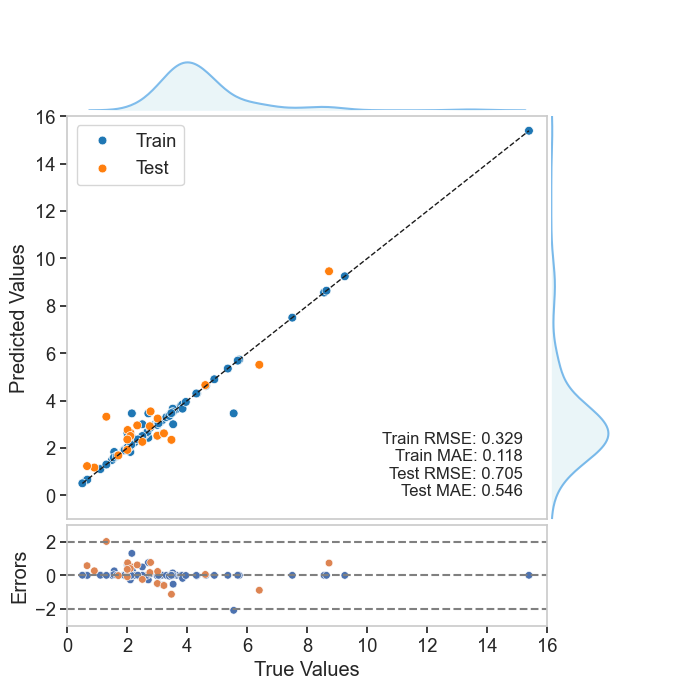

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcdefaults()  
from matplotlib import rcParams
print("Current font:", rcParams['font.family'])
sns.set(style="whitegrid", font_scale=1.2)

y_train_pred = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_pred)

print("y_train min:", y_train.min(), "| y_train_pred min:", y_train_pred.min())
print("y_test min:", y_test.min(),   "| y_test_pred min:", y_pred.min())

plot_df = pd.DataFrame({
    'True': np.concatenate([y_train, y_test]),
    'Pred': np.concatenate([y_train_pred, y_pred]),
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test)
})

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 3,
    width_ratios=[0.1, 4, 1],
    height_ratios=[1, 4, 1],
    hspace=0.03, wspace=0.02) 

ax_kde_x = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=plot_df, x='True', fill=True, color='#ADD8E6', ax=ax_kde_x, linewidth=0)
sns.kdeplot(data=plot_df, x='True', fill=False, color='#2C91E0', ax=ax_kde_x, linewidth=1.5, alpha=0.6)
ax_kde_x.set_ylim(0, ax_kde_x.get_ylim()[1] * 2)  

ax_kde_x.axis("off")

ax_main = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=plot_df, x='True', y='Pred', hue='Set', ax=ax_main, s=40, palette=['#1f77b4', '#ff7f0e'])
ax_main.plot([plot_df['True'].min(), plot_df['True'].max()],
             [plot_df['True'].min(), plot_df['True'].max()], 'k--', lw=1)
ax_main.set_xlabel("")
ax_main.tick_params(axis='x', labelbottom=False, bottom=False, length=5)
ax_main.tick_params(axis='y', labelleft=True, left=True, length=5)
ax_main.set_ylabel("Predicted Values")
ax_main.set_xlim(0, 16)
ax_main.set_ylim(-1, 16)
ax_main.set_title("")                         
ax_main.legend(title=None)
ax_main.grid(False)

metric_text = f"Train RMSE: {train_rmse:.3f}\nTrain MAE: {train_mae:.3f}\nTest RMSE: {test_rmse:.3f}\nTest MAE: {test_mae:.3f}"
ax_main.text(0.95, 0.05, metric_text, fontsize=12, ha='right', va='bottom',
             transform=ax_main.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

ax_kde_y = fig.add_subplot(gs[1, 2], sharey=ax_main)
sns.kdeplot(data=plot_df, y='Pred', fill=True, color='#ADD8E6', ax=ax_kde_y, linewidth=0)
sns.kdeplot(data=plot_df, y='Pred', fill=False, color='#2C91E0', ax=ax_kde_y, linewidth=1.5, alpha=0.6)
ax_kde_y.set_xlim(0, ax_kde_y.get_xlim()[1] * 2)  

ax_kde_y.axis("off")

ax_resid = fig.add_subplot(gs[2, 1], sharex=ax_main)
errors = np.concatenate([y_train_pred - y_train, y_pred - y_test])
sns.scatterplot(x=plot_df['True'], y=errors, hue=plot_df['Set'], ax=ax_resid, s=30, legend=False)
ax_resid.axhline(0, ls='--', color='gray')
ax_resid.axhline(2, ls='--', color='gray')
ax_resid.axhline(-2, ls='--', color='gray')
ax_resid.set_ylim(-3, 3)
ax_resid.set_yticks([-2, 0, 2])              
ax_resid.set_ylabel("Errors")
ax_resid.set_xlabel("True Values")
ax_resid.set_xlim(0, 16)
ax_resid.grid(False)
ax_resid.tick_params(axis='x', bottom=True, length=5)
ax_resid.tick_params(axis='y', left=True, length=5)
plt.setp(ax_kde_x.get_xticklabels(), visible=False)
plt.setp(ax_kde_y.get_yticklabels(), visible=False)

plt.tight_layout()
fig.savefig("xgb_scatter_with_metrics.png", dpi=300)
plt.show()
